In [1]:
import os

import graspy as gs
from graspy.embed import OmnibusEmbed, ClassicalMDS
from graspy.cluster import GaussianCluster
from graspy.utils import import_graph, pass_to_ranks

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
files = os.listdir('../desikan_hnu1/')
subjects = np.asarray([s.split('_')[0] for s in files])
graph_labels = [s.split('_de')[0] for s in files]
graphs = [np.load('../desikan_hnu1/' + f) for f in files]

labels = np.repeat(np.arange(30), 10)
y = labels

## HNU1 Desikan DWIs

There are 30 subjects, 10 scans each for total of 300 graphs. We use Desikan atlas, which has 70 vertices/ROIs.

### Visualizing sample graphs

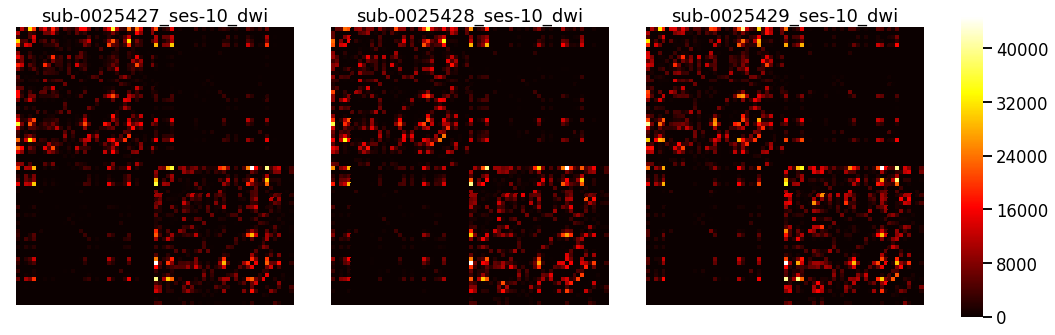

In [3]:
with sns.plotting_context("talk", font_scale=1):
    fig, (ax1, ax2, ax3, axcb) = plt.subplots(ncols=4, figsize=(15,5), gridspec_kw={'width_ratios':[1,1,1,0.08]})
    ax1.get_shared_y_axes().join(ax2,ax3)
    sns.heatmap(graphs[0], cmap='hot', square=True, xticklabels=False, yticklabels=False, ax=ax1, cbar=False)
    ax1.set_title(graph_labels[0])
    sns.heatmap(graphs[10], cmap='hot', square=True, xticklabels=False, yticklabels=False, ax=ax2, cbar=False)
    ax2.set_title(graph_labels[10])
    sns.heatmap(graphs[20], cmap='hot', square=True, xticklabels=False, yticklabels=False, ax=ax3, cbar_ax=axcb)
    ax3.set_title(graph_labels[20])
    fig.tight_layout()

### PTR

In [4]:
graphs = [pass_to_ranks(g) for g in graphs]

### Visualizing sample graphs after PTR

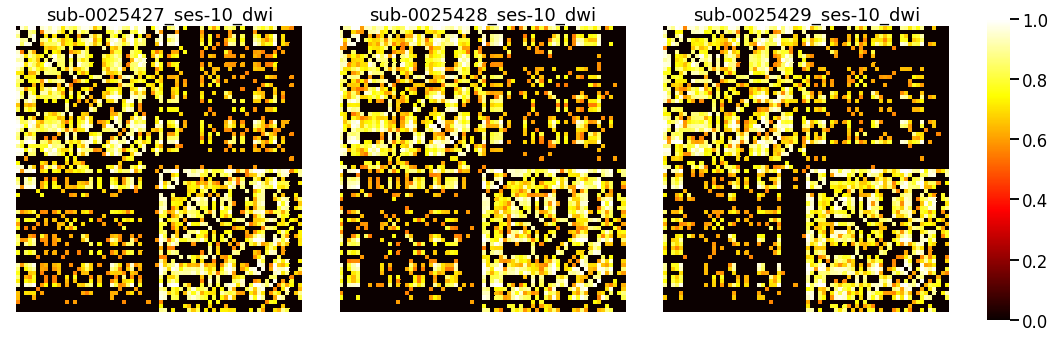

In [5]:
with sns.plotting_context("talk", font_scale=1):
    fig, (ax1, ax2, ax3, axcb) = plt.subplots(ncols=4, figsize=(15,5), gridspec_kw={'width_ratios':[1,1,1,0.08]})
    ax1.get_shared_y_axes().join(ax2,ax3)
    sns.heatmap(graphs[0], cmap='hot', square=True, xticklabels=False, yticklabels=False, ax=ax1, cbar=False)
    ax1.set_title(graph_labels[0])
    sns.heatmap(graphs[10], cmap='hot', square=True, xticklabels=False, yticklabels=False, ax=ax2, cbar=False)
    ax2.set_title(graph_labels[10])
    sns.heatmap(graphs[20], cmap='hot', square=True, xticklabels=False, yticklabels=False, ax=ax3, cbar_ax=axcb)
    ax3.set_title(graph_labels[20])
    fig.tight_layout()

## T-Semipar o Omni o PTR

1. Embed all 300 graphs using omni ($d=50$ since I don't have working ZG)
2. Compute pairwise Frobenus norms

In [6]:
omni = OmnibusEmbed(k=50)
omni.fit(graphs)
dissimilarity = omni.get_dissimilarity()

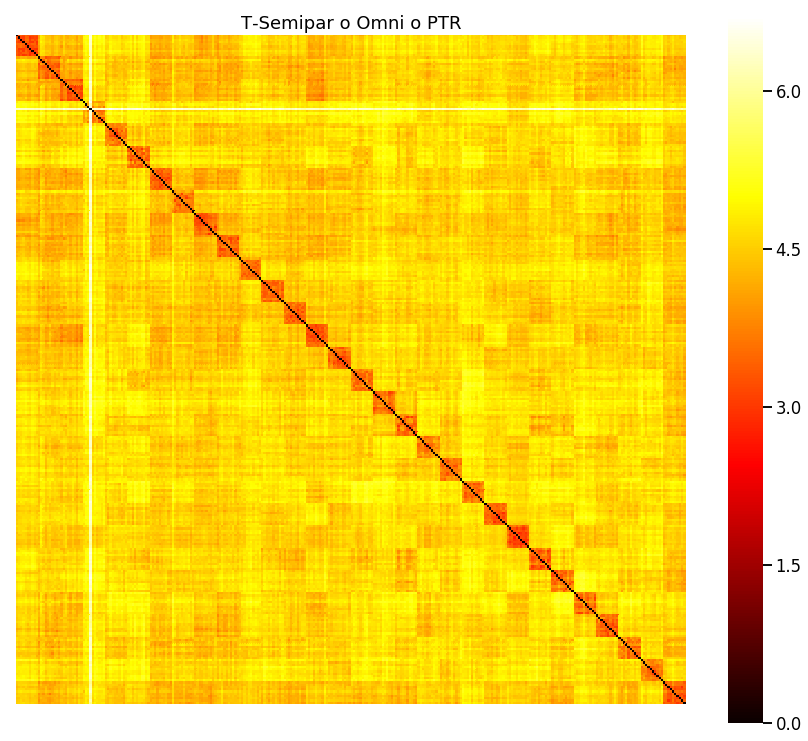

In [7]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 13))
    plot = sns.heatmap(dissimilarity, cmap='hot', square=True, xticklabels=False, yticklabels=False)
    plot.set_title("T-Semipar o Omni o PTR")

## Compute cMDS and visualize first 5 embedded dimensions with largest singular values

Each label corresponds to a subject. Seems to bug out when I give strings as labels so stick with numbers

In [9]:
cmds = ClassicalMDS(n_components=25)
X = cmds.fit_transform(dissimilarity)
X = np.fliplr(X)

<Figure size 1080x1080 with 0 Axes>

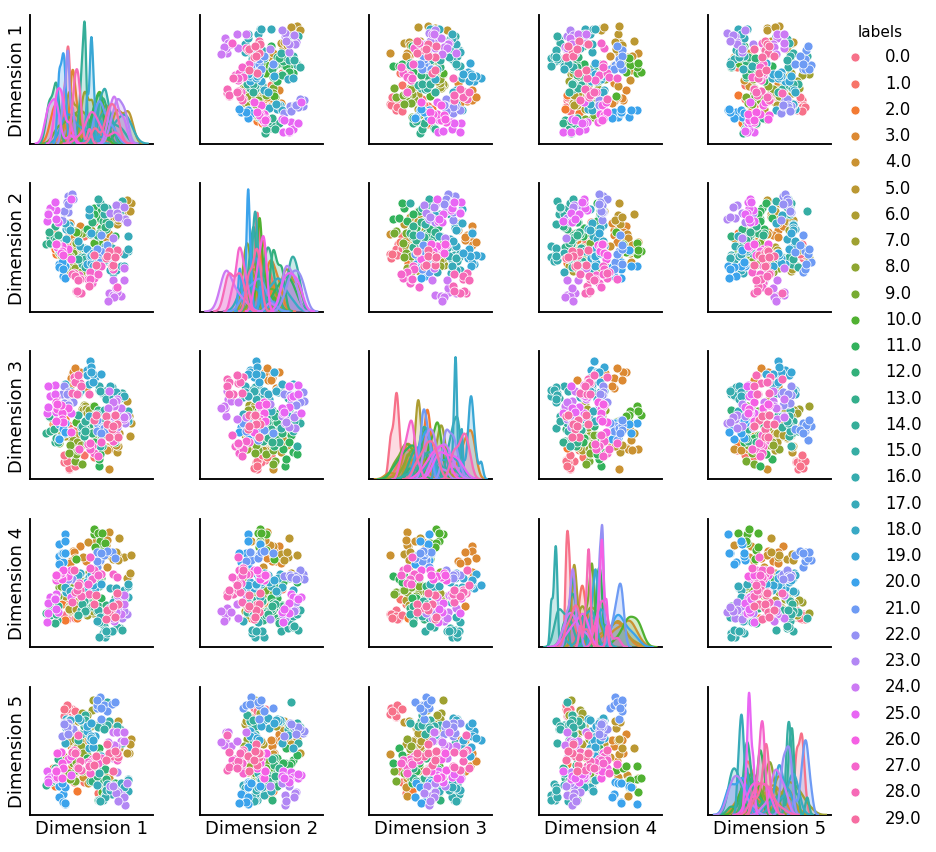

In [10]:
X_ = np.hstack([y.reshape(-1, 1), X])
col_names =  ['Dimension {}'.format(i) for i in range(1, X_.shape[1])]
df = pd.DataFrame(X_, columns=['labels'] + col_names)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 15))
    pairs = sns.pairplot(df, hue = 'labels', vars=col_names[:5])
    pairs.set(xticklabels=[], yticklabels=[], yticks=[], xticks=[])

## Running GMM clustering up to 30 clusters

In [11]:
gclust = GaussianCluster(max_components=30)

gclust.fit(X, y)

GaussianCluster(covariance_type=None, max_components=None, random_state=None)

### Plot ARI as function of number of estimated clusters

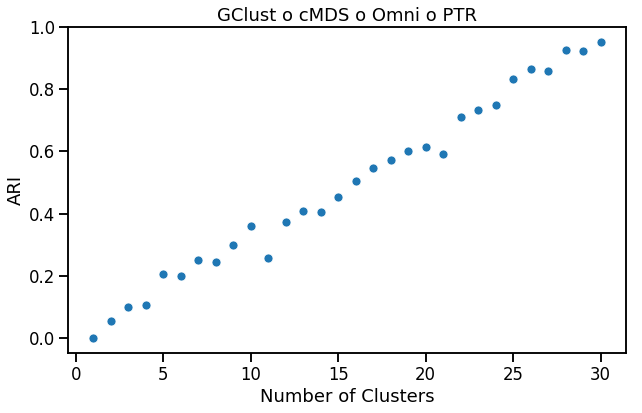

In [12]:
aris = gclust.ari_

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o PTR')

### Plot BIC as function of number of estimated clusters

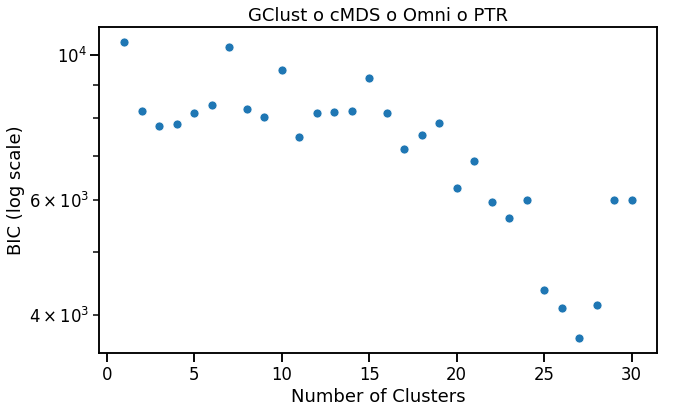

In [15]:
bics = gclust.bic_

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(bics) +1), bics)
    plot.set(yscale='log')
    plot.set(xlabel='Number of Clusters', ylabel='BIC (log scale)', title='GClust o cMDS o Omni o PTR')

## Comparing results to K-Means of vectorized adjacencies

Let $vec(A)$ be the vector of upper triangle of $A$ without its diagnal. 

Let $X = [vec(A_1), vec(A_2), \ldots, vec(A_n)]^T \in \mathbb{R}^{m\times \frac{n(n-1)}{2}}$ where $m$ is the number of graphs and $n$ is the number of vertices in each graph.

With Desikan atlas, we get $X \in \mathbb{R}^{300\times 2415}$.

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [40]:
graphs = [pass_to_ranks(g) for g in graphs]

In [41]:
idx = np.triu_indices(70, k=0)
vectors = [graphs[i][idx] for i in range(len(graphs))]
X = np.stack(vectors)

In [45]:
X.shape

(300, 2485)

In [47]:
aris = []

for k in range(1, 31):
    # print("Trying {} means".format(k))
    kmeans = KMeans(n_clusters=k)
    predictions = kmeans.fit_predict(X)
    aris.append(adjusted_rand_score(y, predictions))

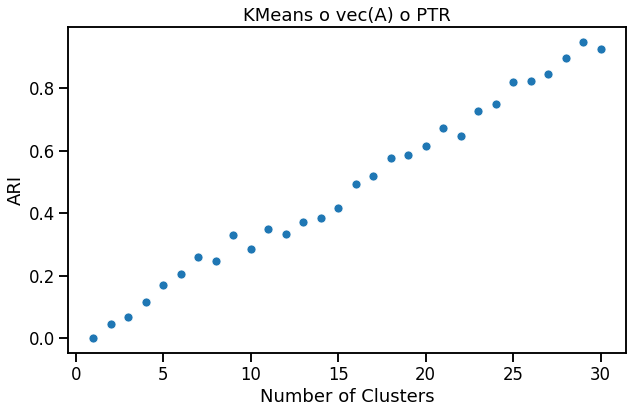

In [48]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='KMeans o vec(A) o PTR')